# <center>Eye Tracking Project</center>

## Table of Contents

1. [Import Requirements](#Import-Requirements)
2. [Context Information](#Context-information)
3. [Paper 1: IPA](#The-Index-of-Pupillary-Activity)
    1. [Version 1](#Version-1) Hardcoded Version 
    2. [Version 2](#Version-2) PyWavelet Version
5. [Paper 2: LHIPA](#The-Low/High-Index-of-Pupillary-Activity)
6. [Paper 3: RIPA](#Toward-a-Real-Time-Index-of-Pupillary-Activity)
7. [PyPil Base Class](#Base-Class)
    1. [IPA Subclass](#IPA-Subclass)
    2. [LHIPA Subclass](#LHIPA-Subclass)
    3. [RIPA Theorectical Implementation](#Theoretical-Implementation)
8. [Lindlbauer Datasets](#Applied-to-the-Lindlbauer-Datasets)

## Import Requirements
These are the required packages to make the program work, I tried to limit it to only what was found within the original pseudocode with only a few additional ones where I thought they would be best used.

In [1]:
import glob
import math
import numpy as np
import os
import pandas as pd
import pywt

from matplotlib import pyplot as plt

## Context information
I will be trying to implement three pupillometric measures from Duchowski's papers regarding: 
- 1) Index of Pupillary Activity (IPA)
- 2) Low/High Index of Pupillary Activity (LHIPA)
- 3) Reat-Time-Index of Pupillary Activity (RIPA) 

Which are all loosely based on Marshall's Index of Cognitive Activity (ICA) from 2002.

## The Index of Pupillary Activity
The paper Duchowski et al. (2018) is the basis for this and it is the first iteration of their eye-tracked measure of the requency of pupil diameter oscillation. What this paper achieves is creating/replicating the Index of Cognitive Activity (ICA) and in general improving upon it without necessarily being copyrighted. 


## Version 1
This version was created before I was aware that PyWavelet could do 90% of what I needed for the code. This can be found on the Github under Unmaintained Code as Python Implementation v1. But is otherwise not up to date.

## Version 2
This version is the final one that is used within the implementation and is far cleaner code because of it.

### IPA Implementation
There are roughly six formulas that are used within the paper to calculate IPA. Below we will go through each one and how they are implemented, what their variables are, and how they connect to one another. 


### Wavelet Decomposition
All of the five formulas listed below construct the first part of our python implementation from the Duchowski et al. (2018) paper. Each of them will be noted in their explicit part in the end result but are as such not hardcode calculated in this current version of the project.

#### Dyadic Wavelet Function
The first of many functions, this one represents the wavelet function used in the analysis and is representative of the $wavelet$ argument in the function. For this specific rendition of the code, we assume that they are using the "sym16" version as that is what is used within the pseudo-code.

We will do this with the following variables:
- $x(t)$: pupil diameter signal over time
- $\psi(t)$: the mother wavelet function 
    - (Symlet-16)
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
\psi_{j,k}(t) = 2^{j/2} \psi(2^j t - k), \quad \text{where } j, k \in \mathbb{Z} \qquad \text{(0)}
$$

#### Integral Transformation of Wavelet Coefficients
This step is far more complicated as it goes through several iterations of it within the Duchowski et al. (2018) paper, but we'll mainly focus on the steps taht we can complete here.

(For the sake of space, repeated variables will not be given descriptions)

##### Decomposition of the Wavelet Analysis w.r.t. coefficients
This formula is implicit to our calculation but is not directly incorporated into our code.

Variable representation:
- $L^2(\mathbb{R})$: Noting that $x(t)$ is a square-integrable function
    - (meaning it won't become infinitely large when squared or integrated)
- $\sum_{j,k = -\infty}^{\infty}$: represents the sum over all possible combinations of j and k that are integers.
- $c_{j,k}$: wavelet coefficients of $\psi_{j,k}(t)$
- $x(t)$: pupil diameter signal
- $\psi_{j,k}(t)$: the mother wavelet function 
    - (Symlet-16)


$$
x \in L^2(\mathbb{R}): x(t) = \sum_{j,k = -\infty}^{\infty} c_{j,k} \psi_{j,k}(t), \quad j,k \in \mathbb{Z} \qquad \text{(1)}
$$

##### Inner Product Calculation of the Wavelet Coefficients
This formula computes the wavelet coefficients by taking the inner product of the input $x(t)$ and tells us how well the function performs at different scales and translations. From this formula onward, these are all explicitly done under the hood of "pywt.wavedec" which is the PyWavelet Decomposition function.

Variable representation:
- $c_{j,k}$: already noted
- $\int_{-\infty}^{\infty}$: Integral of the formula, represents area under the curve
- $x(t)$: already noted
- $\overline{\psi_{j,k}(t)}$: We are taking the complex conjugate of our previous wavelet function. 
    - (this ensures that the result is a real value)
- $dt$: The integration of the variable t

$$
c_{j,k} = \int_{-\infty}^{\infty} x(t) \overline{\psi_{j,k}(t)} dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z} \qquad \text{(2)}
$$

##### Substitution Property for Formula (0) and Formula (2)
Variables inlcuded from Formula (0):
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
c_{j,k} = 2^{j/2} \int_{-\infty}^{\infty} x(t) \overline{\psi(2^j t - k)} \, dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z}
\qquad \text{(3)}
$$

##### The Wavelet Coefficients in their final form
This formula gives us the similarity between the signal and the wavelet function at each scale and position.

Variable representation:
- $\{W_\psi x(t)\}(j, k)$: The wavelet transformation of $x(t)$ using $\psi$
- $\langle x(t), \psi_{j,k}(t) \rangle$: The inner product reprsented in another way from formula (3)

$$
= \{W_\psi x(t)\}(j, k) = \langle x(t), \psi_{j,k}(t) \rangle
\qquad \text{(4)}
$$

##### Modulus Maximum Detection
This formula is meant to identify the sharp poitns of variation within the signal, we do this after we have transformed the signal and determined the coefficients found in the previous formulas.
$$
\left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \leq \left| \langle x(t_0), \psi_{j,k} \rangle \right| \geq \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| 
$$

$$
\text{and} 
$$

$$
\quad \left\{ \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \quad \text{or} \quad \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| \right\} \qquad \text{(5)}
$$

#### Base Class

In [2]:
class PyPil:
    """
    Purpose: 
    This is the base class used to calculate three types of formulas 
    relating to pupil measurement with subclasses for each of the specific
    calculations. Since each of these calculations serve as an extension 
    of the previous one and as such is listed in the corresponding order 
    within the class and the only parts that are in this one are the items 
    shared by all three.
  
    The three papers and calculations in question and their subclass name:
    IPA:
    1) Index of Pupillary Activity (IPA) from Duchowski et al. (2018)
    
    LHIPA:
    2) Low/High Index of Pupillary Activity (LHIPA) from Duchowski et al. (2020)
    
    RIPA:
    3) Reat-Time-Index of Pupillary Activity (RIPA) from Jayawardena et al. (2022)
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
        
    ...
    
    Methods:
    calculate_timestamps()
        This returns the difference from the first and last point of measure.
   
    compute_modmax(cD2)
        
    
    compute_threshold(detect, mode="hard")
    
    calculate_ipa(cD2t)
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level = 2):
        try:
            import numpy as np
            import math
            import pywt
        except ImportError as e:
            raise ImportError("A required library is not imported, verify that numpy, math, and pywt are imported.")
        
        self.pupil_data_diam = list(pupil_data['diameter'])
        self.pupil_data_time = list(pupil_data['world_index'])
        self.wavelet = wavelet
        self.periodization = periodization
        self.level = level
        
    # NOTE: This one is changed quite a lot from the original version in the 
    # psuedocode. This is because it uses timestamp compared to what the data 
    # we have.
    
    # CONCERN: The dataframes did not have an "actual" timestamp option, so 
    # I had to make do with what I had and the "world_index" was the closest
    # to it.
    def calculate_timestamps(self):
        """
        Purpose: 
        This calculates the difference in time from the last point and the first point.
        
        ...
        
        Features:
        No input features
        
        ...
        
        Output:
        This will output a numeric value that is the difference in time between the two points.
        
        """
        tt = self.pupil_data_time[-1] - self.pupil_data_time[0]
#         print("\nTimestamp Calculation:")
#         print("tt:", tt)
        return float(tt)
        
    def compute_modmax(self, d):
        """
        Purpose:
        This will find where the modulus is grater than both of its 
        neighbours. 
        
        ...
        
        Features:
        cD2 : array
            This is the normalization of Detail coefficients at level 2
        
        ...
        
        Output:
        detect : array
        
        
        """    
        m = [0.0] * len(d)
        for i in range(len(d)):
            m[i] = math.fabs(d[i])
            
        t = [0.0] * len(d)
        for i in range(len(d)):    
            ll = m[i-1] if i >= 1 else m[i]
            oo = m[i]
            rr = m[i+1] if i < len(d)-2 else m[i]
            
            if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
                t[i] = math.sqrt(d[i]**2)
            else:
                t[i] = 0.0
#         print("\nModmax Calculation:")
#         print(detect)
        return t


    # CONCERN: whether we do hard or softe thresholding, everything
    # turns to 0 with this for every single dataframe we put inside.
    # I suspect this is a problem with my calculations.
    def compute_threshold(self, detect, mode="hard"):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        thresh = np.std(detect) * math.sqrt(2.0*np.log2(len(detect)))
        cD2t = pywt.threshold(detect,thresh,mode)
#         print("\nCalculate Threshold:")
#         print(cD2t)
        return cD2t
    
    def calculate_ipa(self, cD2t):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        ctr = 0
        for i in range(len(cD2t)):
            if math.fabs(cD2t[i]) > 0: 
                ctr += 1
        ipa = float(ctr)/ self.calculate_timestamps()
#         print("\nIPA:")
#         print(ipa)
        return ipa

#### IPA Subclass
Please note that after several revisions, these parts were to be partitioned into only the subclass that is below as LHIPA and RIPA were going to use part of the original IPA code but not all of it.

In [3]:
class IPA(PyPil):
    """
    Purpose: 
    This class calculates the Index of Pupillary Activity (IPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
        
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2):
        super().__init__(pupil_data, wavelet, periodization, level)
        
        # Perform IPA calculation upon initialization
        cA2, cD2, cD1 = self.ipa_wavelet_decomposition()
        cA2[:], cD2[:], cD1[:] = self.ipa_normalize_coefficients(cA2, cD2, cD1, self.level)
        detect = self.compute_modmax(cD2[:])
        cD2t = self.compute_threshold(detect)
        self.ipa = self.calculate_ipa(cD2t)
        print(f"IPA Calculation: {self.ipa}")

    def ipa_wavelet_decomposition(self):
        """
        Purpose: 
        This takes formula (0) to (4) from the paper and does it all with very minimal
        code. It takes sin the pupil diameter, uses sym16, per, and level 2 as its inputs 
        as they were listed in the original paper.
        
        ...
        
        Features:
        No input features
                
        ...
        
        Output:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        
        """
        # This was created to look like the one on the pseudocode in the paper
        cA2, cD2, cD1 = pywt.wavedec(self.pupil_data_diam, self.wavelet, mode=self.periodization, level=self.level)
#             print("Wavelet Decomposition:")
#             print("\n", "cA2:",  cA2)
#             print("\n", "cD2:", cD2)
#             print("\n", "cD1:", cD1)
        return cA2, cD2, cD1 
        
    def ipa_normalize_coefficients(self, cA2, cD2, cD1, level):
        """
        Purpose:
        This will normalize the coefficients for each one we created. 
        
        ...
        
        Features:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        level : int
            The level of granularity done within the decomposition (default: 2)
        
        ...
        
        Output:
        cA2[:] : array
            This is the normalization of Approximation coefficients at level 2
        cD2[:] : array
            This is the normalization of Detail coefficients at level 2
        cD1[:] : array
            This is the normalization of Detail coefficients at level 1
        
        """
        # normalize by 1/2 j , j = 2 for 2- level DWT
        # This is now changed to account for if we change the level
        cA2[:] = [x / math.sqrt(2.0 * level) for x in cA2] 
        cD2[:] = [x / math.sqrt(2.0 * level) for x in cD2]
        cD1[:] = [x / math.sqrt(1.0 * level) for x in cD1] 
        return cA2[:], cD2[:], cD1[:]        


### The Low/High Index of Pupillary Activity
This is the only version of the code that we'll have available for the LHIPA implementation. It is primarily utilizing the class PyPil to avoid reusing unchanged part of the code and the differences in formulas will be noted below and within the code itself.

#### Discrete Wavelet Transformation
This formula is different from the Dyadic Wavelet Transformation because it is missing its scaling factor and it now includes a summation of k and $g_k$ within the formula itself.

Dyadic:
$$
\psi_{j,k}(t) = 2^{j/2} \psi(2^j t - k), \quad \text{where } j, k \in \mathbb{Z}
$$

Discrete:
$$
x^{j-1}_\psi(t) = \sum_k g_k x^{j}_\psi(2t+k) \qquad \text{(6)}
$$

#### Low Freq / High Freq Ratio
This part is the larger difference within the code is the LF/HF ratio. This is meant to characterize the autonomic balance of the frequencies. We do this by substituting $j$ with $\frac{1}{2} \log_2(n)$ and making sure to multipy the denominator by 2 to keep it balanced.

$$
\frac{(x_\psi^{\frac{1}{2} \log_2(n)} (t)}{x^1_\psi\left(2^{\frac{1}{2}\log_2(n)}t\right)} \qquad \text{(7)}
$$

We then plug this all into the very similar thresholding (but change its mode) and we get a brand new type of IPA calculation.

#### LHIPA Subclass

In [4]:
class LHIPA(PyPil):
    """
    Purpose: 
    This class calculates the Low/High Index of Pupillary Activity (LHIPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2):
        super().__init__(pupil_data, wavelet, periodization, level)
        
      
        # Perform LHIPA calculation upon initialization
        self.max_level = self.lhipa_wavelet_decomposition(self.pupil_data_diam)
        self.hif, self.lof = 1, int(self.max_level/2)
        cD_H, cD_L  = self.lhipa_normalize_coefficients(self.pupil_data_diam, self.max_level)
        cD_LH = self.lhipa_ratio(cD_H[:], cD_L[:])
        cD_LHm = self.compute_modmax(cD_LH)
        cD_LHt = self.compute_threshold(cD_LHm, mode="less")
        self.lhipa = self.calculate_ipa(cD_LHt)
        print(f"LHIPA Calculation: {self.lhipa}")
        
    def lhipa_wavelet_decomposition(self, d):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        w = pywt.Wavelet('sym16')
        self.max_level = pywt.dwt_max_level(len(d),filter_len=w.dec_len)
#         print("\n", "Max Level:")
#         print("\n", max_level)
        return self.max_level
        
    def lhipa_normalize_coefficients(self, d, max_level):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_H = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.hif)
        cD_L = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.lof)
        cD_H[:] = [x / math.sqrt(2**self.hif) for x in cD_H]
        cD_L[:] = [x / math.sqrt(2**self.lof) for x in cD_L]
        return cD_H[:], cD_L[:]   
    
    def lhipa_ratio(self, cD_H, cD_L):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_LH = cD_L.copy()
        for i in range(len(cD_L)):
            den = cD_H[((2**self.lof)//(2**self.hif))*i]
            if den != 0:
                cD_LH[i] = cD_L[i] / den
            else: 
                cD_LH[i] = cD_L[i] / 0.00000000001
        return cD_LH


### Toward a Real-Time Index of Pupillary Activity
Unlike the other two, the accesibility of the code or even psuedocode for RIPA is very limited and changes a lot of the fundamental parts of it. After doing some additional research on the content of the implementation, here is how it would roughly be done if we had the time and ability to ask some questions reqarding the code they used.

#### The Differences
There are many large differences between RIPA and the other two version of the implementation LH/IPA. Here are some of the most notable parts:

##### Real Time vs Offline
Fundamentally RIPA is meant to take on "Real-Time" whereas the original IPA and Low/High IPA take in data offline. 

##### Wavelet Analysis vs Savitzky-Golay filtering
LH/IPA use Dyadic/Discrete Wavelet Analysis and other scaling/translation transformations of the data, but RIPA just uses Savitzky-Golay filtering on the pupil diameter which allows for parallel computation of the low- and high-frequency responses. As noted in the paper by Jayawardena et al. (2022), this also in turn reduces the total complexity of the model as well.

##### Data Storage vs Ring Buffers
Effectively a Ring Buffer is a more efficient method for managing data when there is a fixed size to it. This is especially useful in Real Time applications because it allows for constant access to the data and FIFO behaviour for the items within it. There is definitely more to this, but my limited knowledge on Ring Buffers tell me that they are far better sutied to RT data which is why it was used over the original methodology.

##### Normalization Methods
The normalization process is a bit similar to that of LHIPA, but there is also the inclusion of a length buffer and inversion to make it directly proporitional to the pupil diameter. 


### Theoretical Implementation
Given we don't have the ability to do this in Real-Time and the psuedocode is not as easily readable/translatable into a class, here is what we would do given the option to implement it:

1. We would use the Python library collections.deque to create a ring buffer
2. We would then use the Python library scipy.signal for Savitzky-Golay filtering and apply this to the stored data in our collections.deque.
3. We then use a similar normalization process to the LHIPA on this data but also include the length buffer and inversion to get the low- and high-frequency responses.
4. We then apply the existing Modulus Maxima that we previously were using.
5. We then calculate the RIPA by counting when the ratio is outside our determined bounds.

### Applied to the Lindlbauer Datasets
We're going to use glob.glob again from the PyPil Dataframe Processor and iterate through the two groups of folders that the class created for us. Then we'll get both the IPA and LHIPA for each one and make some visualizations out of them. 

In the public Github version of this, there will be a directory that is noted after the os.chdir(r"...") , but for the sake of not showing my folder grouping I omitted it in the repo.

In [5]:
# This is the version where the ONLY thing we did to the data was remove NaNs/Nulls
# and we did nothing else to it.
os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\trimmed_files")
trim_csv_files = glob.glob("*.csv")
trim_csv_files

['study01_p02-pupil_positions-trimmed-02_trimmed.csv',
 'study01_p02-pupil_positions-trimmed_trimmed.csv',
 'study01_p02-pupil_positions_trimmed.csv',
 'study01_p03-pupil_positions_trimmed.csv',
 'study01_p04-pupil_positions_trimmed.csv',
 'study01_p05-pupil_positions_trimmed.csv',
 'study01_p06-pupil_positions_trimmed.csv',
 'study02_p01-pupil_positions_trimmed.csv',
 'study03_pupil_positions_trimmed.csv']

In [6]:
ipa_list = []
lhipa_list = []

for csv in trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    ipa_list.append(ipa.ipa)
    lhipa_list.append(lhipa.lhipa)
    print("\n")


Name of File: study01_p02-pupil_positions-trimmed-02_trimmed.csv
IPA Calculation: 0.00392156862745098
LHIPA Calculation: 0.08235294117647059



Name of File: study01_p02-pupil_positions-trimmed_trimmed.csv
IPA Calculation: 0.002430939226519337
LHIPA Calculation: 0.08132596685082873



Name of File: study01_p02-pupil_positions_trimmed.csv
IPA Calculation: 0.0015230900450834653
LHIPA Calculation: 0.03953941757036676



Name of File: study01_p03-pupil_positions_trimmed.csv
IPA Calculation: 0.0047083282377400025
LHIPA Calculation: 0.03858383270147976



Name of File: study01_p04-pupil_positions_trimmed.csv
IPA Calculation: 0.00024804663276696017
LHIPA Calculation: 0.03850923973707057



Name of File: study01_p05-pupil_positions_trimmed.csv
IPA Calculation: 0.004843517138599106
LHIPA Calculation: 0.040673124689518135



Name of File: study01_p06-pupil_positions_trimmed.csv
IPA Calculation: 0.0027922561429635146
LHIPA Calculation: 0.04039463886820551



Name of File: study02_p01-pupil_posit

In [7]:
# This is the version where we assumed that each data point was measured more than one time
# and we are averaging those measurements out.

os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\grouped_trimmed_folder")
grouped_trim_csv_files = glob.glob("*.csv")
grouped_trim_csv_files

['study01_p02-pupil_positions-trimmed-02_trimmed.csv',
 'study01_p02-pupil_positions-trimmed_trimmed.csv',
 'study01_p02-pupil_positions_trimmed.csv',
 'study01_p03-pupil_positions_trimmed.csv',
 'study01_p04-pupil_positions_trimmed.csv',
 'study01_p05-pupil_positions_trimmed.csv',
 'study01_p06-pupil_positions_trimmed.csv',
 'study02_p01-pupil_positions_trimmed.csv',
 'study03_pupil_positions_trimmed.csv']

In [8]:
g_ipa_list = []
g_lhipa_list = []

for csv in grouped_trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    g_ipa_list.append(ipa.ipa)
    g_lhipa_list.append(lhipa.lhipa)
    print("\n")


Name of File: study01_p02-pupil_positions-trimmed-02_trimmed.csv
IPA Calculation: 0.00196078431372549
LHIPA Calculation: 0.040392156862745096



Name of File: study01_p02-pupil_positions-trimmed_trimmed.csv
IPA Calculation: 0.0013259668508287293
LHIPA Calculation: 0.03955801104972376



Name of File: study01_p02-pupil_positions_trimmed.csv
IPA Calculation: 0.0007310832216400634
LHIPA Calculation: 0.02028755940051176



Name of File: study01_p03-pupil_positions_trimmed.csv
IPA Calculation: 0.0015286779992662346
LHIPA Calculation: 0.02066772655007949



Name of File: study01_p04-pupil_positions_trimmed.csv
IPA Calculation: 0.00043408160734218035
LHIPA Calculation: 0.019843730621356814



Name of File: study01_p05-pupil_positions_trimmed.csv
IPA Calculation: 0.0020491803278688526
LHIPA Calculation: 0.02036761053154496



Name of File: study01_p06-pupil_positions_trimmed.csv
IPA Calculation: 0.0013030528667163069
LHIPA Calculation: 0.019856043683296104



Name of File: study02_p01-pupil_p

In [9]:
df = pd.read_csv('study03_pupil_positions_trimmed.csv')

In [15]:
df.head()

,world_index,diameter
1721,1792,52.215358
1722,1793,52.210732
1723,1794,52.096521
1724,1795,51.972080
1725,1796,51.880530


In [16]:
initial_rows = 2  # Change this according to your requirements
initial_subset = df.iloc[:initial_rows]
ipa_calculator = IPA(initial_subset)
ipa_lister = []
world_index_lister = []

for i in range(initial_rows, len(df)):
    subset = df.iloc[:i+1]  # Increase the subset of data
    ipa_calculator = IPA(subset)  # Calculate IPA for the current subset
    ipa_lister.append(ipa_calculator.ipa)
    world_index_lister.append(subset['world_index'].iloc[-1])

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


IPA Calculation: 0.0
IPA Calculation: 0.0
IPA Calculation: 0.0
IPA Calculation: 0.0
IPA Calculation: 0.0
IPA Calculation: 0.16666666666666666
IPA Calculation: 0.14285714285714285
IPA Calculation: 0.125
IPA Calculation: 0.1111111111111111
IPA Calculation: 0.1
IPA Calculation: 0.09090909090909091
IPA Calculation: 0.08333333333333333
IPA Calculation: 0.07692307692307693
IPA Calculation: 0.07142857142857142
IPA Calculation: 0.06666666666666667
IPA Calculation: 0.0625
IPA Calculation: 0.058823529411764705
IPA Calculation: 0.05555555555555555
IPA Calculation: 0.05263157894736842
IPA Calculation: 0.05
IPA Calculation: 0.047619047619047616
IPA Calculation: 0.045454545454545456
IPA Calculation: 0.043478260869565216
IPA Calculation: 0.041666666666666664
IPA Calculation: 0.04
IPA Calculation: 0.038461538461538464
IPA Calculation: 0.037037037037037035
IPA Calculation: 0.03571428571428571
IPA Calculation: 0.034482758620689655
IPA Calculation: 0.0
IPA Calculation: 0.0
IPA Calculation: 0.03125
IPA Ca

IPA Calculation: 0.0032733224222585926
IPA Calculation: 0.0032679738562091504
IPA Calculation: 0.0032626427406199023
IPA Calculation: 0.004885993485342019
IPA Calculation: 0.004878048780487805
IPA Calculation: 0.00487012987012987
IPA Calculation: 0.004862236628849271
IPA Calculation: 0.003236245954692557
IPA Calculation: 0.0032310177705977385
IPA Calculation: 0.0032258064516129032
IPA Calculation: 0.00322061191626409
IPA Calculation: 0.003215434083601286
IPA Calculation: 0.0032102728731942215
IPA Calculation: 0.003205128205128205
IPA Calculation: 0.0032
IPA Calculation: 0.003194888178913738
IPA Calculation: 0.003189792663476874
IPA Calculation: 0.0031847133757961785
IPA Calculation: 0.003179650238473768
IPA Calculation: 0.0031746031746031746
IPA Calculation: 0.003169572107765452
IPA Calculation: 0.0031645569620253164
IPA Calculation: 0.00315955766192733
IPA Calculation: 0.0031545741324921135
IPA Calculation: 0.0031496062992125984
IPA Calculation: 0.0031446540880503146
IPA Calculation: 

IPA Calculation: 0.0010775862068965517
IPA Calculation: 0.001076426264800861
IPA Calculation: 0.001075268817204301
IPA Calculation: 0.0010741138560687433
IPA Calculation: 0.001072961373390558
IPA Calculation: 0.0010718113612004287
IPA Calculation: 0.0010706638115631692
IPA Calculation: 0.0010695187165775401
IPA Calculation: 0.0010683760683760685
IPA Calculation: 0.0010672358591248667
IPA Calculation: 0.0010660980810234541
IPA Calculation: 0.0010649627263045794
IPA Calculation: 0.0010638297872340426
IPA Calculation: 0.0010626992561105207
IPA Calculation: 0.0010615711252653928
IPA Calculation: 0.0010604453870625664
IPA Calculation: 0.001059322033898305
IPA Calculation: 0.0010582010582010583
IPA Calculation: 0.0010570824524312897
IPA Calculation: 0.0010559662090813093
IPA Calculation: 0.0010548523206751054
IPA Calculation: 0.001053740779768177
IPA Calculation: 0.0010526315789473684
IPA Calculation: 0.0010515247108307045
IPA Calculation: 0.0010504201680672268
IPA Calculation: 0.00104931794

IPA Calculation: 0.0008396305625524769
IPA Calculation: 0.0008389261744966443
IPA Calculation: 0.0008382229673093043
IPA Calculation: 0.0008375209380234506
IPA Calculation: 0.0008368200836820083
IPA Calculation: 0.0008361204013377926
IPA Calculation: 0.000835421888053467
IPA Calculation: 0.0008347245409015025
IPA Calculation: 0.0008340283569641367
IPA Calculation: 0.0008333333333333334
IPA Calculation: 0.0008326394671107411
IPA Calculation: 0.0008319467554076539
IPA Calculation: 0.0008312551953449709
IPA Calculation: 0.0008305647840531562
IPA Calculation: 0.0008298755186721991
IPA Calculation: 0.0008291873963515755
IPA Calculation: 0.0008285004142502071
IPA Calculation: 0.0008278145695364238
IPA Calculation: 0.0008271298593879239
IPA Calculation: 0.0008264462809917355
IPA Calculation: 0.0008257638315441783
IPA Calculation: 0.0008250825082508251
IPA Calculation: 0.0008244023083264633
IPA Calculation: 0.0008237232289950577
IPA Calculation: 0.0008230452674897119
IPA Calculation: 0.0008223

IPA Calculation: 0.0014104372355430183
IPA Calculation: 0.0014094432699083862
IPA Calculation: 0.0014084507042253522
IPA Calculation: 0.0014074595355383533
IPA Calculation: 0.0014064697609001407
IPA Calculation: 0.0014054813773717498
IPA Calculation: 0.0014044943820224719
IPA Calculation: 0.0014035087719298245
IPA Calculation: 0.001402524544179523
IPA Calculation: 0.001401541695865452
IPA Calculation: 0.0014005602240896359
IPA Calculation: 0.0013995801259622112
IPA Calculation: 0.0013986013986013986
IPA Calculation: 0.001397624039133473
IPA Calculation: 0.0013966480446927375
IPA Calculation: 0.0013956734124214933
IPA Calculation: 0.001394700139470014
IPA Calculation: 0.0013937282229965157
IPA Calculation: 0.001392757660167131
IPA Calculation: 0.0013917884481558804
IPA Calculation: 0.0013908205841446453
IPA Calculation: 0.001389854065323141
IPA Calculation: 0.001388888888888889
IPA Calculation: 0.0013879250520471894
IPA Calculation: 0.0013869625520110957
IPA Calculation: 0.0013860013860

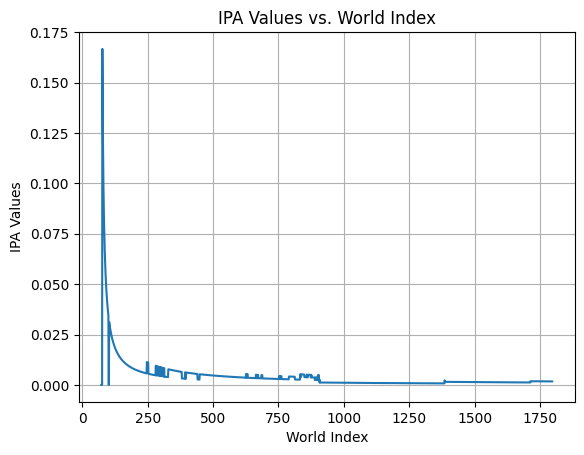

In [21]:
import matplotlib.pyplot as plt

# Your code to create ipa_values and world_index_values lists goes here

# Plot the graph
plt.plot(world_index_lister, ipa_lister, linestyle='-')
plt.title('IPA Values vs. World Index')
plt.xlabel('World Index')
plt.ylabel('IPA Values')
plt.grid(True)
plt.show()

In [22]:
initial_rows = 2  # Change this according to your requirements
initial_subset = df.iloc[:initial_rows]
ipa_calculator = LHIPA(initial_subset)
ipa_lister = []
world_index_lister = []

for i in range(initial_rows, len(df)):
    subset = df.iloc[:i+1]  # Increase the subset of data
    ipa_calculator = LHIPA(subset)  # Calculate IPA for the current subset
    ipa_lister.append(ipa_calculator.ipa)
    world_index_lister.append(subset['world_index'].iloc[-1])

ValueError: Value of level must be greater than 0.

In [ ]:
ipa_values = []

# Iterate over the dataframe, gradually increasing the subset of data
for i in range(1, len(df) + 1):
    subset = df.iloc[:i]  # Increase the subset of data
    ipa_calculator = IPA(subset)  # Calculate IPA for the current subset
    ipa_values.append(ipa_calculator.ipa)  # Save the IPA value to the list

# Print the list of IPA values
print("IPA Values:", ipa_values)